In [ ]:
import numpy as np
import time
from keras.models import load_model
from solver_backtracking import solve_backtrack, Step
from utils import evaluate_solution

In [6]:
class HybridSudokuSolver:
    def __init__(self, model_path, confidence_threshold=0.95):
        self.model = load_model(model_path)
        self.confidence_threshold = confidence_threshold
    
    def is_valid_move(self, board, row, col, num):
        """Check if a move is valid (doesn't violate Sudoku rules)"""
        if num == 0:
            return True
            
        # Check row
        if num in board[row, :]:
            return False
        
        # Check column
        if num in board[:, col]:
            return False
        
        # Check 3x3 box
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        box = board[box_row:box_row+3, box_col:box_col+3]
        if num in box:
            return False
        
        return True
    
    def print_board(self, board, title="Board"):
        """Print the sudoku board in a readable format"""
        print(f"\n{title}:")
        print("-" * 25)
        for i in range(9):
            if i % 3 == 0 and i != 0:
                print("-" * 25)
            row_str = ""
            for j in range(9):
                if j % 3 == 0 and j != 0:
                    row_str += "| "
                cell_value = board[i, j]
                row_str += f"{cell_value if cell_value != 0 else '.'} "
            print(row_str)
        print("-" * 25)
    
    def get_model_predictions(self, board):
        """Get model predictions for the current board state"""
        # Normalize input
        board_norm = board.astype(np.float32) / 9.0 - 0.5
        input_board = board_norm.reshape(1, 9, 9, 1)
        
        # Get predictions
        pred = self.model.predict(input_board, verbose=0)
        
        # Get predicted digits and their probabilities
        predicted_digits = np.argmax(pred[0], axis=-1) + 1
        probabilities = np.max(pred[0], axis=-1)
        
        return predicted_digits, probabilities
    
    def solve_with_cnn_first(self, puzzle, true_solution):
        """Use CNN for high-confidence predictions, then backtracking for the rest"""
        original_board = np.array(puzzle, dtype=int)
        true_solution = np.array(true_solution, dtype=int)
        
        print("=" * 60)
        print("HYBRID SUDOKU SOLVER: CNN + BACKTRACKING")
        print("=" * 60)
        
        # Step 1: Run CNN and get high-confidence predictions
        print("\n1. RUNNING CNN PREDICTIONS...")
        cnn_start_time = time.time()
        
        predicted_digits, probabilities = self.get_model_predictions(original_board)
        cnn_partial_board = original_board.copy()
        
        # Only fill cells where CNN has high confidence AND the cell is empty AND the move is valid
        empty_mask = original_board == 0
        high_confidence_mask = probabilities > self.confidence_threshold
        cells_to_fill = empty_mask & high_confidence_mask
        
        print(f"CNN confidence threshold: {self.confidence_threshold}")
        print(f"High-confidence predictions: {np.sum(cells_to_fill)} cells")
        
        # Count valid vs invalid high-confidence predictions
        valid_predictions = 0
        invalid_predictions = 0
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    predicted_value = predicted_digits[i, j]
                    if self.is_valid_move(cnn_partial_board, i, j, predicted_value):
                        cnn_partial_board[i, j] = predicted_value
                        valid_predictions += 1
                    else:
                        # Leave invalid predictions as 0 (don't fill them)
                        invalid_predictions += 1
                        cells_to_fill[i, j] = False  # Remove from filled count
        
        cnn_time = time.time() - cnn_start_time
        
        # Calculate REAL accuracy (against true solution, not just validity)
        cnn_filled_cells = np.sum(cells_to_fill)
        cnn_correct_predictions = 0
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    if cnn_partial_board[i, j] == true_solution[i, j]:
                        cnn_correct_predictions += 1
        
        cnn_accuracy = cnn_correct_predictions / cnn_filled_cells if cnn_filled_cells > 0 else 0.0
        
        self.print_board(original_board, "ORIGINAL PUZZLE")
        self.print_board(cnn_partial_board, "AFTER CNN (HIGH-CONFIDENCE + VALID PREDICTIONS)")
        
        print(f"\nCNN RESULTS:")
        print(f"Time taken: {cnn_time:.4f} seconds")
        print(f"High-confidence cells found: {valid_predictions + invalid_predictions}")
        print(f"  Valid predictions: {valid_predictions}")
        print(f"  Invalid predictions: {invalid_predictions} (not filled)")
        print(f"Cells actually filled by CNN: {cnn_filled_cells}")
        print(f"CNN prediction accuracy: {cnn_accuracy * 100:.2f}%")
        print(f"Remaining empty cells: {np.sum(cnn_partial_board == 0)}")
        
        # Check if CNN solved it completely
        if np.array_equal(cnn_partial_board, true_solution):
            print("\n🎉 CNN SOLVED THE PUZZLE COMPLETELY!")
            return cnn_partial_board, cnn_time, 0, cnn_accuracy, 1.0
        
        # Step 2: Use backtracking for remaining empty cells
        remaining_empty = np.sum(cnn_partial_board == 0)
        print(f"\n2. RUNNING BACKTRACKING FOR {remaining_empty} REMAINING CELLS...")
        backtrack_start_time = time.time()
        
        # Use backtracking to solve remaining cells
        backtrack_board = cnn_partial_board.copy()
        steps = []
        
        success = solve_backtrack(backtrack_board, steps)
        backtrack_time = time.time() - backtrack_start_time
        
        if success:
            # Final evaluation
            final_empty_acc, final_all_acc = evaluate_solution(backtrack_board, original_board, true_solution)
            
            self.print_board(backtrack_board, "FINAL SOLUTION (AFTER BACKTRACKING)")
            
            print(f"\nBACKTRACKING RESULTS:")
            print(f"Time taken: {backtrack_time:.4f} seconds")
            print(f"Number of backtracking steps: {len(steps)}")
            print(f"Remaining cells solved correctly: {final_empty_acc * 100:.2f}%")
            print(f"Final all cells accuracy: {final_all_acc * 100:.2f}%")
            
            # Verify final solution
            if np.array_equal(backtrack_board, true_solution):
                print("🎉 PUZZLE SOLVED CORRECTLY!")
            else:
                print("❌ Final solution does not match expected result")
                print("Expected solution:")
                self.print_board(true_solution, "EXPECTED SOLUTION")
            
            return backtrack_board, cnn_time, backtrack_time, cnn_accuracy, final_all_acc
        
        else:
            print("❌ Backtracking failed to solve the puzzle")
            return None, cnn_time, backtrack_time, cnn_accuracy, 0.0

In [27]:
if __name__ == "__main__":
    import os
    from keras import saving
    
    # Load model
    cwd = os.getcwd()
    #model_path = os.path.join(cwd, "model", "sudoku_cnn_512_filters")
    model_path = os.path.join(cwd, "model", "sudoku_cnn_256_filters")
    
    try:
        solver = HybridSudokuSolver(model_path, confidence_threshold=0.98)
        
        # Test with easy puzzle
        
        easy_puzzle = [
            [5,3,0, 0,7,0, 0,0,0],
            [6,0,0, 1,9,5, 0,0,0],
            [0,9,8, 0,0,0, 0,6,0],

            [8,0,0, 0,6,0, 0,0,3],
            [4,0,0, 8,0,3, 0,0,1],
            [7,0,0, 0,2,0, 0,0,6],

            [0,6,0, 0,0,0, 2,8,0],
            [0,0,0, 4,1,9, 0,0,5],
            [0,0,0, 0,8,0, 0,7,9]
        ]

        easy_solution = [
            [5,3,4, 6,7,8, 9,1,2],
            [6,7,2, 1,9,5, 3,4,8],
            [1,9,8, 3,4,2, 5,6,7],

            [8,5,9, 7,6,1, 4,2,3],
            [4,2,6, 8,5,3, 7,9,1],
            [7,1,3, 9,2,4, 8,5,6],

            [9,6,1, 5,3,7, 2,8,4],
            [2,8,7, 4,1,9, 6,3,5],
            [3,4,5, 2,8,6, 1,7,9]
        ]
        print("🧪 TESTING MEDIUM PUZZLE:")
        result, cnn_time, backtrack_time, cnn_acc, final_acc = solver.solve_with_cnn_first(
            easy_puzzle, easy_solution
        )
        
        print(f"\n📊 SUMMARY FOR EASY PUZZLE:")
        print(f"CNN Time: {cnn_time:.4f}s")
        print(f"Backtracking Time: {backtrack_time:.4f}s")
        print(f"Total Time: {cnn_time + backtrack_time:.4f}s")
        print(f"CNN Prediction Accuracy: {cnn_acc * 100:.2f}%")
        print(f"Final Accuracy: {final_acc * 100:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

🧪 TESTING MEDIUM PUZZLE:
HYBRID SUDOKU SOLVER: CNN + BACKTRACKING

1. RUNNING CNN PREDICTIONS...
CNN confidence threshold: 0.98
High-confidence predictions: 3 cells

ORIGINAL PUZZLE:
-------------------------
5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
-------------------------
8 . . | . 6 . | . . 3 
4 . . | 8 . 3 | . . 1 
7 . . | . 2 . | . . 6 
-------------------------
. 6 . | . . . | 2 8 . 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 
-------------------------

AFTER CNN (HIGH-CONFIDENCE + VALID PREDICTIONS):
-------------------------
5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
-------------------------
8 . . | . 6 . | . . 3 
4 . . | 8 5 3 | . . 1 
7 . . | . 2 . | . . 6 
-------------------------
. 6 . | . . 7 | 2 8 4 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 
-------------------------

CNN RESULTS:
Time taken: 2.7089 seconds
High-confidence cells found: 3
  Valid predictions: 3
  Invalid predictions: 0 (not filled)
Cells actual

In [12]:
import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download("rohanrao/sudoku")
print("Path:", path)

# List files to see what's available
print("Files in dataset:")
for file in os.listdir(path):
    print(file)

# Load the CSV
data = pd.read_csv(os.path.join(path, "sudoku.csv"))
print("Data loaded!")
print(data.shape)

c:\Users\kosta\OneDrive\Documents\Fakultlet\MITNOP\vezbe\zadaci\mitnop\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resuming download from 556793856 bytes (93702942 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/rohanrao/sudoku?dataset_version_number=1 (556793856/650496798) bytes left.


100%|██████████| 620M/620M [00:08<00:00, 10.8MB/s]

Extracting files...


Path: C:\Users\kosta\.cache\kagglehub\datasets\rohanrao\sudoku\versions\1
Files in dataset:
sudoku.csv
Data loaded!
(9000000, 2)


Loading model: CNN_256_filters
Loading model: CNN_512_filters
RUNNING HYBRID SOLVER BENCHMARK SUITE

📊 Testing Model: CNN_256_filters
------------------------------------------------------------

  Difficulty: EASY
    Confidence Threshold: 0.95
      Puzzle 1, Run 1: CNN filled 5/51, Time: 0.770s, Solved: ✓
      Puzzle 1, Run 2: CNN filled 5/51, Time: 0.125s, Solved: ✓
      Puzzle 1, Run 3: CNN filled 5/51, Time: 0.123s, Solved: ✓
      Puzzle 2, Run 1: CNN filled 2/49, Time: 0.093s, Solved: ✓
      Puzzle 2, Run 2: CNN filled 2/49, Time: 0.084s, Solved: ✓
      Puzzle 2, Run 3: CNN filled 2/49, Time: 0.099s, Solved: ✓
    Confidence Threshold: 0.90
      Puzzle 1, Run 1: CNN filled 6/51, Time: 0.164s, Solved: ✓
      Puzzle 1, Run 2: CNN filled 6/51, Time: 0.116s, Solved: ✓
      Puzzle 1, Run 3: CNN filled 6/51, Time: 0.115s, Solved: ✓
      Puzzle 2, Run 1: CNN filled 3/49, Time: 0.078s, Solved: ✓
      Puzzle 2, Run 2: CNN filled 3/49, Time: 0.084s, Solved: ✓
      Puzzle 2, Run

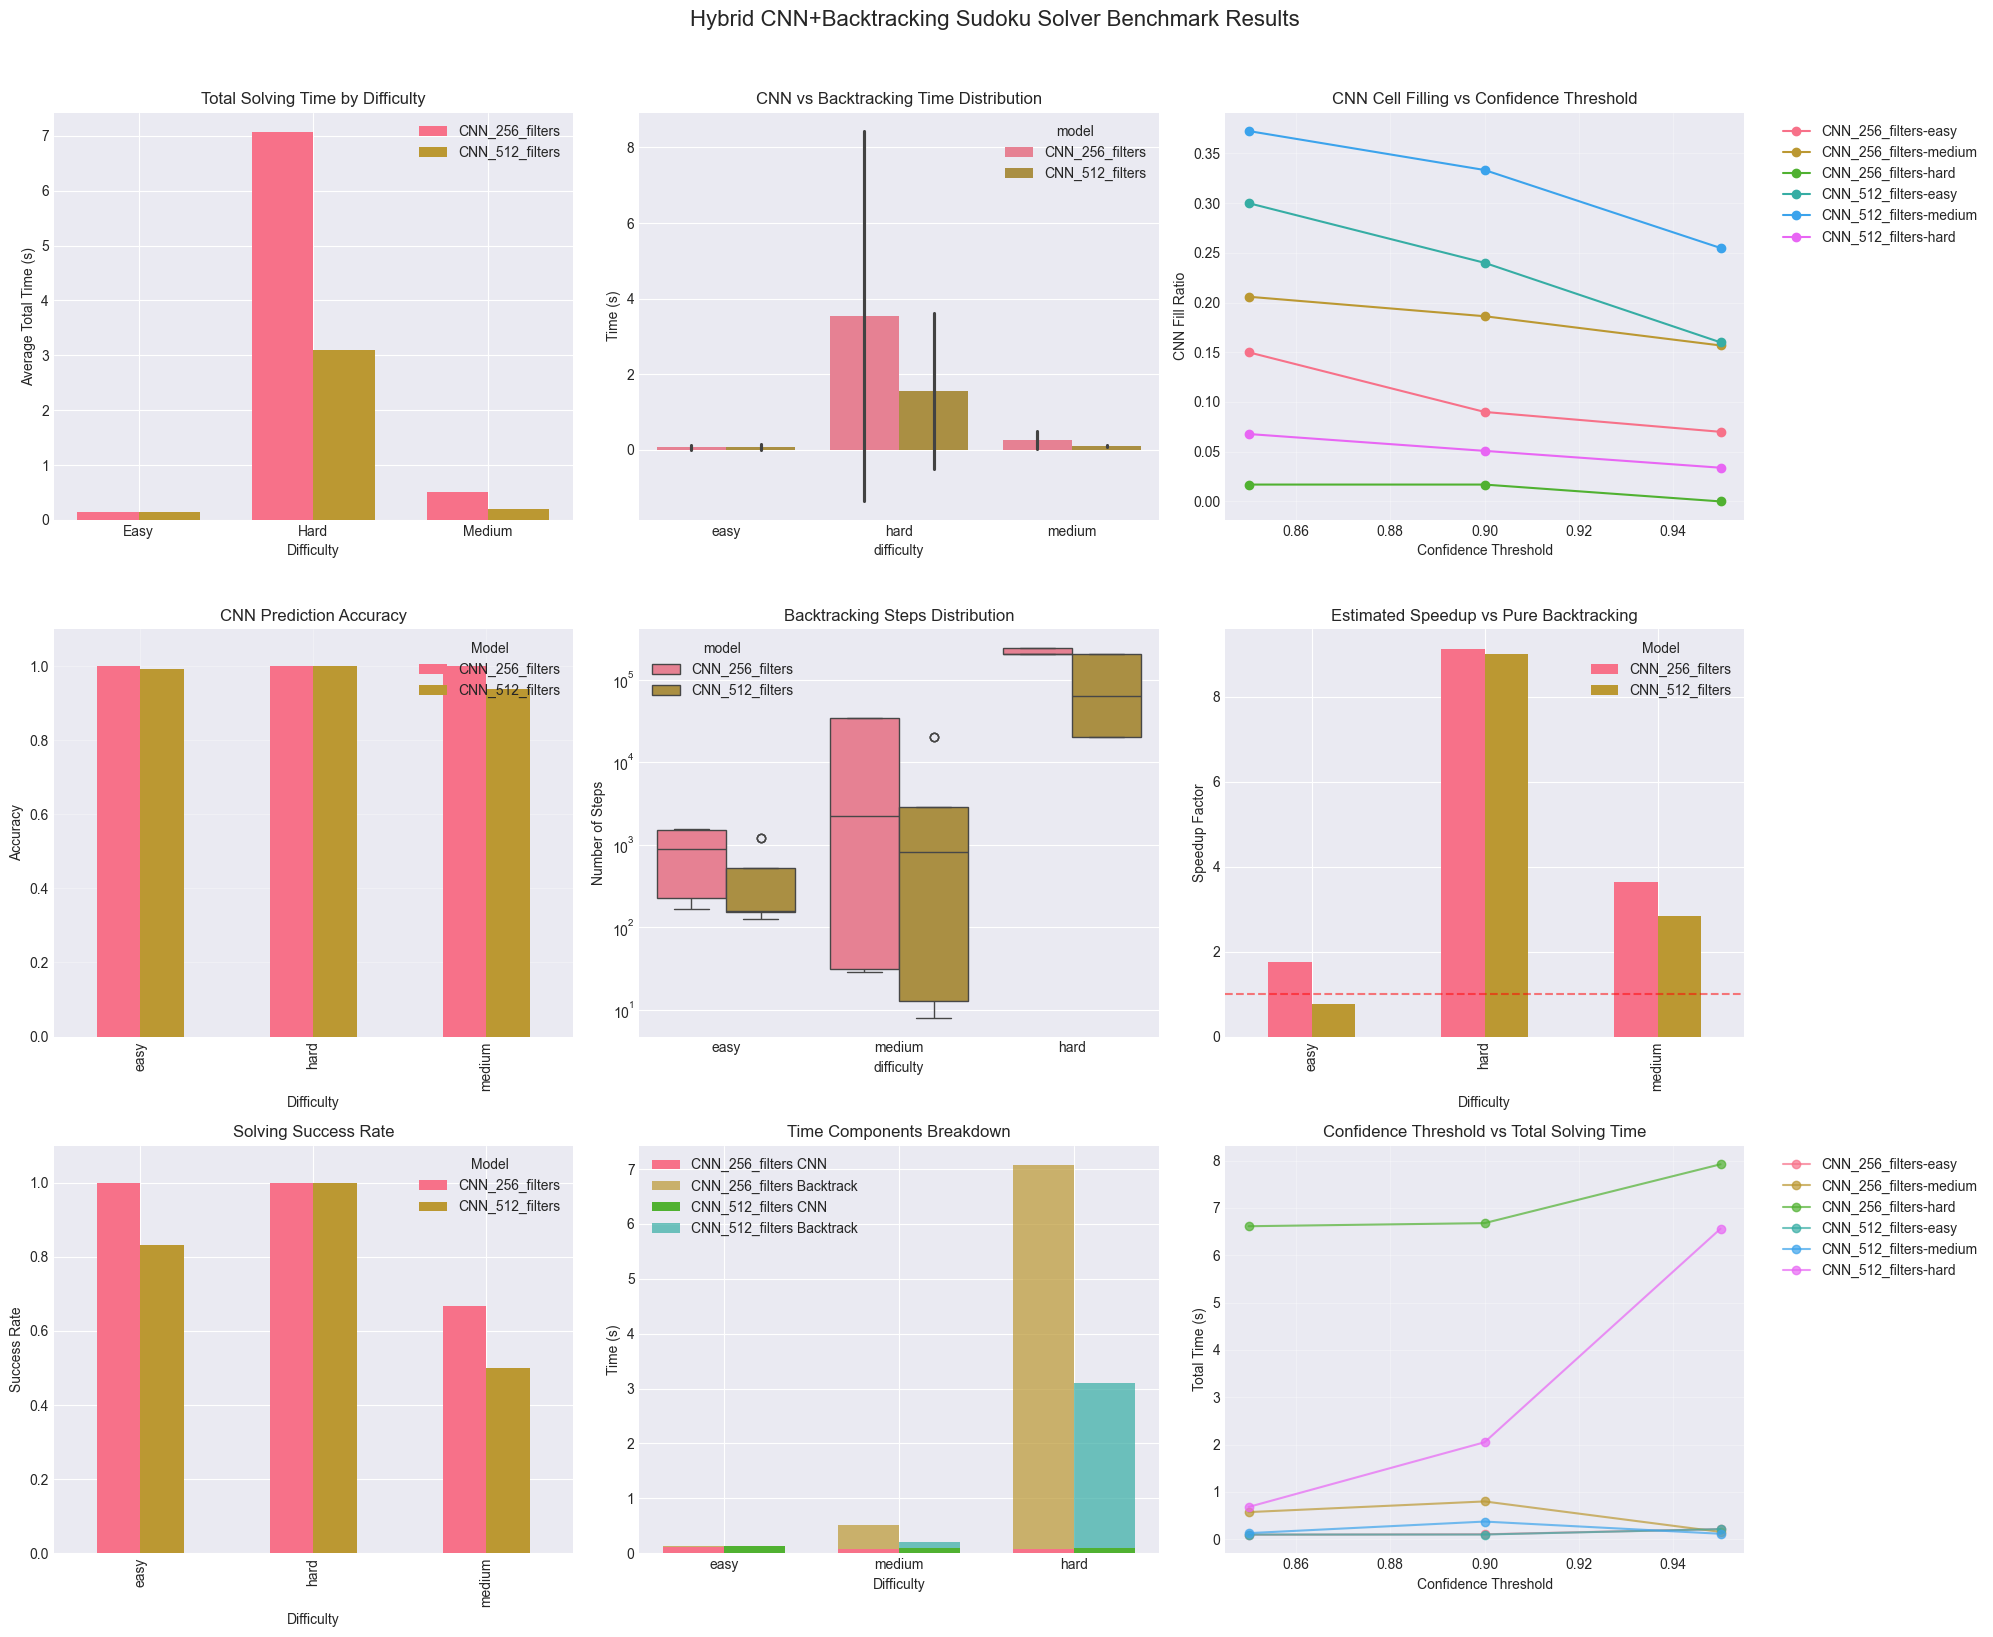


PERFORMANCE COMPARISON SUMMARY

Speedup of CNN_256_filters over CNN_512_filters:
difficulty
easy      1.005222
hard      2.282091
medium    2.458655
Name: speedup, dtype: float64

DETAILED SUMMARY STATISTICS
                           total_time                         cnn_time  \
                                 mean     std     min     max     mean   
model           difficulty                                               
CNN_256_filters easy           0.1400  0.1589  0.0774  0.7699   0.1148   
                hard           7.0709  0.6310  6.3808  8.0603   0.0706   
                medium         0.5107  0.6162  0.0710  2.1759   0.0830   
CNN_512_filters easy           0.1392  0.1544  0.0938  0.7570   0.1287   
                hard           3.0984  2.5854  0.6787  6.6796   0.0901   
                medium         0.2077  0.2094  0.0881  0.6613   0.0920   

                           backtrack_time cnn_cells_filled cnn_accuracy  \
                                     mean        

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import os
from collections import defaultdict


class HybridBenchmarkSuite:
    """Comprehensive benchmarking suite for hybrid CNN+Backtracking Sudoku solvers"""
    
    def __init__(self, model_paths: Dict[str, str], confidence_thresholds: List[float] = [0.95, 0.98, 0.99]):
        """
        Initialize benchmark suite with multiple models
        
        Args:
            model_paths: Dictionary mapping model names to paths
            confidence_thresholds: List of confidence thresholds to test
        """
        self.models = {}
        self.model_paths = model_paths
        self.confidence_thresholds = confidence_thresholds
        
        # Load all models
        for name, path in model_paths.items():
            print(f"Loading model: {name}")
            self.models[name] = load_model(path)
        
        # Define test puzzles for each difficulty
        self.test_puzzles = self._get_test_puzzles()
        
        # Store results
        self.results = defaultdict(list)
    
    def _get_test_puzzles(self):
        """Get test puzzles for each difficulty level"""
        puzzles = {
            'easy': [],
            'medium': [],
            'hard': []
        }
        
        # Easy puzzles (30-35 clues)
        puzzles['easy'].append({
            'puzzle': [
                [5,3,0, 0,7,0, 0,0,0],
                [6,0,0, 1,9,5, 0,0,0],
                [0,9,8, 0,0,0, 0,6,0],
                [8,0,0, 0,6,0, 0,0,3],
                [4,0,0, 8,0,3, 0,0,1],
                [7,0,0, 0,2,0, 0,0,6],
                [0,6,0, 0,0,0, 2,8,0],
                [0,0,0, 4,1,9, 0,0,5],
                [0,0,0, 0,8,0, 0,7,9]
            ],
            'solution': [
                [5,3,4, 6,7,8, 9,1,2],
                [6,7,2, 1,9,5, 3,4,8],
                [1,9,8, 3,4,2, 5,6,7],
                [8,5,9, 7,6,1, 4,2,3],
                [4,2,6, 8,5,3, 7,9,1],
                [7,1,3, 9,2,4, 8,5,6],
                [9,6,1, 5,3,7, 2,8,4],
                [2,8,7, 4,1,9, 6,3,5],
                [3,4,5, 2,8,6, 1,7,9]
            ]
        })
        
        puzzles['easy'].append({
            'puzzle': [
                [0,0,3, 0,2,0, 6,0,0],
                [9,0,0, 3,0,5, 0,0,1],
                [0,0,1, 8,0,6, 4,0,0],
                [0,0,8, 1,0,2, 9,0,0],
                [7,0,0, 0,0,0, 0,0,8],
                [0,0,6, 7,0,8, 2,0,0],
                [0,0,2, 6,0,9, 5,0,0],
                [8,0,0, 2,0,3, 0,0,9],
                [0,0,5, 0,1,0, 3,0,0]
            ],
            'solution': [
                [4,8,3, 9,2,1, 6,5,7],
                [9,6,7, 3,4,5, 8,2,1],
                [2,5,1, 8,7,6, 4,9,3],
                [5,4,8, 1,3,2, 9,7,6],
                [7,2,9, 5,6,4, 1,3,8],
                [1,3,6, 7,9,8, 2,4,5],
                [3,7,2, 6,8,9, 5,1,4],
                [8,1,4, 2,5,3, 7,6,9],
                [6,9,5, 4,1,7, 3,8,2]
            ]
        })
        
        # Medium puzzles (25-30 clues)
        puzzles['medium'].append({
            'puzzle': [
                [0,0,0, 2,6,0, 7,0,1],
                [6,8,0, 0,7,0, 0,9,0],
                [1,9,0, 0,0,4, 5,0,0],
                [8,2,0, 1,0,0, 0,4,0],
                [0,0,4, 6,0,2, 9,0,0],
                [0,5,0, 0,0,3, 0,2,8],
                [0,0,9, 3,0,0, 0,7,4],
                [0,4,0, 0,5,0, 0,3,6],
                [7,0,3, 0,1,8, 0,0,0]
            ],
            'solution': [
                [4,3,5, 2,6,9, 7,8,1],
                [6,8,2, 5,7,1, 4,9,3],
                [1,9,7, 8,3,4, 5,6,2],
                [8,2,6, 1,9,5, 3,4,7],
                [3,7,4, 6,8,2, 9,1,5],
                [9,5,1, 7,4,3, 6,2,8],
                [5,1,9, 3,2,6, 8,7,4],
                [2,4,8, 9,5,7, 1,3,6],
                [7,6,3, 4,1,8, 2,5,9]
            ]
        })
        
        puzzles['medium'].append({
            'puzzle': [
                [0,2,0, 6,0,8, 0,0,0],
                [5,8,0, 0,0,9, 7,0,0],
                [0,0,0, 0,4,0, 0,0,0],
                [3,7,0, 0,0,0, 5,0,0],
                [6,0,0, 0,0,0, 0,0,4],
                [0,0,8, 0,0,0, 0,1,3],
                [0,0,0, 0,2,0, 0,0,0],
                [0,0,9, 8,0,0, 0,3,6],
                [0,0,0, 3,0,6, 0,9,0]
            ],
            'solution': [
                [1,2,3, 6,7,8, 4,5,9],
                [5,8,4, 2,3,9, 7,6,1],
                [9,6,7, 1,4,5, 3,2,8],
                [3,7,1, 4,9,2, 5,8,6],
                [6,9,5, 7,8,3, 2,4,1],
                [2,4,8, 5,6,1, 9,7,3],
                [8,3,6, 9,2,4, 1,5,7],
                [4,1,9, 8,5,7, 2,3,6],
                [7,5,2, 3,1,6, 8,9,4]
            ]
        })
        
        # Hard puzzles (17-25 clues)
        puzzles['hard'].append({
            'puzzle': [
                [0,0,0, 2,9,0, 0,0,0],
                [0,4,0, 1,0,0, 0,0,0],
                [0,2,0, 0,7,0, 0,8,1],
                [0,7,0, 4,2,0, 0,9,0],
                [0,0,0, 0,0,0, 0,3,0],
                [0,0,5, 0,0,6, 0,0,0],
                [0,0,0, 9,4,0, 0,2,3],
                [0,0,0, 0,0,3, 0,0,0],
                [0,0,1, 0,0,0, 8,0,0]
            ],
            'solution': [
                [1,6,8, 2,9,5, 3,4,7],
                [3,4,7, 1,6,8, 9,5,2],
                [5,2,9, 3,7,4, 6,8,1],
                [6,7,3, 4,2,1, 5,9,8],
                [2,1,4, 5,8,9, 7,3,6],
                [9,8,5, 7,3,6, 2,1,4],
                [8,5,6, 9,4,7, 1,2,3],
                [7,9,2, 8,1,3, 4,6,5],
                [4,3,1, 6,5,2, 8,7,9]
            ]
        })
        
        puzzles['hard'].append({
            'puzzle': [
                [0,0,0, 2,9,0, 0,0,0],
                [0,4,0, 1,0,0, 0,0,0],
                [0,2,0, 0,7,0, 0,8,1],
                [0,7,0, 4,2,0, 0,9,0],
                [0,0,0, 0,0,0, 0,3,0],
                [0,0,5, 0,0,6, 0,0,0],
                [0,0,0, 9,4,0, 0,2,3],
                [0,0,0, 0,0,3, 0,0,0],
                [0,0,1, 0,0,0, 8,0,0]
            ],
            'solution': [
                [1,6,8, 2,9,5, 3,4,7],
                [3,4,7, 1,6,8, 9,5,2],
                [5,2,9, 3,7,4, 6,8,1],
                [6,7,3, 4,2,1, 5,9,8],
                [2,1,4, 5,8,9, 7,3,6],
                [9,8,5, 7,3,6, 2,1,4],
                [8,5,6, 9,4,7, 1,2,3],
                [7,9,2, 8,1,3, 4,6,5],
                [4,3,1, 6,5,2, 8,7,9]
            ]
        })
        
        return puzzles
    
    def is_valid_move(self, board, row, col, num):
        """Check if a move is valid"""
        if num == 0:
            return True
        
        # Check row
        if num in board[row, :]:
            return False
        
        # Check column
        if num in board[:, col]:
            return False
        
        # Check 3x3 box
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        box = board[box_row:box_row+3, box_col:box_col+3]
        if num in box:
            return False
        
        return True
    
    def solve_with_hybrid(self, model, puzzle, solution, confidence_threshold):
        """Solve puzzle using hybrid approach"""
        original_board = np.array(puzzle, dtype=int)
        true_solution = np.array(solution, dtype=int)
        
        # Metrics to track
        metrics = {
            'cnn_time': 0,
            'backtrack_time': 0,
            'total_time': 0,
            'cnn_cells_filled': 0,
            'cnn_cells_correct': 0,
            'cnn_accuracy': 0,
            'backtrack_steps': 0,
            'final_accuracy': 0,
            'solved': False,
            'total_empty_cells': np.sum(original_board == 0),
            'confidence_threshold': confidence_threshold
        }
        
        # Step 1: CNN predictions
        cnn_start = time.time()
        
        # Normalize and predict
        board_norm = original_board.astype(np.float32) / 9.0 - 0.5
        input_board = board_norm.reshape(1, 9, 9, 1)
        pred = model.predict(input_board, verbose=0)
        
        predicted_digits = np.argmax(pred[0], axis=-1) + 1
        probabilities = np.max(pred[0], axis=-1)
        
        # Fill high-confidence valid predictions
        cnn_board = original_board.copy()
        empty_mask = original_board == 0
        high_conf_mask = probabilities > confidence_threshold
        cells_to_fill = empty_mask & high_conf_mask
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    predicted_value = predicted_digits[i, j]
                    if self.is_valid_move(cnn_board, i, j, predicted_value):
                        cnn_board[i, j] = predicted_value
                        metrics['cnn_cells_filled'] += 1
                        if predicted_value == true_solution[i, j]:
                            metrics['cnn_cells_correct'] += 1
        
        metrics['cnn_time'] = time.time() - cnn_start
        metrics['cnn_accuracy'] = (metrics['cnn_cells_correct'] / metrics['cnn_cells_filled'] 
                                   if metrics['cnn_cells_filled'] > 0 else 0)
        
        # Step 2: Backtracking for remaining cells
        backtrack_start = time.time()
        backtrack_board = cnn_board.copy()
        steps = []
        
        success = solve_backtrack(backtrack_board, steps)
        metrics['backtrack_time'] = time.time() - backtrack_start
        metrics['backtrack_steps'] = len(steps)
        
        if success:
            metrics['solved'] = True
            # Calculate final accuracy
            correct_cells = np.sum(backtrack_board == true_solution)
            metrics['final_accuracy'] = correct_cells / 81
        
        metrics['total_time'] = metrics['cnn_time'] + metrics['backtrack_time']
        
        return metrics
    
    def run_benchmark(self, num_runs: int = 3):
        """Run complete benchmark suite"""
        print("=" * 80)
        print("RUNNING HYBRID SOLVER BENCHMARK SUITE")
        print("=" * 80)
        
        for model_name, model in self.models.items():
            print(f"\n📊 Testing Model: {model_name}")
            print("-" * 60)
            
            for difficulty, puzzle_list in self.test_puzzles.items():
                print(f"\n  Difficulty: {difficulty.upper()}")
                
                for conf_threshold in self.confidence_thresholds:
                    print(f"    Confidence Threshold: {conf_threshold:.2f}")
                    
                    for puzzle_idx, puzzle_data in enumerate(puzzle_list):
                        puzzle = puzzle_data['puzzle']
                        solution = puzzle_data['solution']
                        
                        # Run multiple times for averaging
                        for run in range(num_runs):
                            metrics = self.solve_with_hybrid(
                                model, puzzle, solution, conf_threshold
                            )
                            
                            # Add metadata
                            metrics['model'] = model_name
                            metrics['difficulty'] = difficulty
                            metrics['puzzle_idx'] = puzzle_idx
                            metrics['run'] = run
                            
                            self.results['data'].append(metrics)
                            
                            print(f"      Puzzle {puzzle_idx+1}, Run {run+1}: "
                                  f"CNN filled {metrics['cnn_cells_filled']}/{metrics['total_empty_cells']}, "
                                  f"Time: {metrics['total_time']:.3f}s, "
                                  f"Solved: {'✓' if metrics['solved'] else '✗'}")
        
        # Convert to DataFrame for easier analysis
        self.df_results = pd.DataFrame(self.results['data'])
        return self.df_results
    
    def generate_visualizations(self):
        """Generate comprehensive visualization suite"""
        if not hasattr(self, 'df_results'):
            print("No results to visualize. Run benchmark first.")
            return
        
        # Set style
        plt.style.use('seaborn-v0_8-darkgrid')
        sns.set_palette("husl")
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Time Comparison by Difficulty
        ax1 = plt.subplot(3, 3, 1)
        df_avg = self.df_results.groupby(['model', 'difficulty']).agg({
            'total_time': 'mean',
            'cnn_time': 'mean',
            'backtrack_time': 'mean'
        }).reset_index()
        
        x = np.arange(len(df_avg['difficulty'].unique()))
        width = 0.35
        
        for i, model in enumerate(df_avg['model'].unique()):
            model_data = df_avg[df_avg['model'] == model]
            offset = width * (i - 0.5)
            ax1.bar(x + offset, model_data['total_time'], width, label=model)
        
        ax1.set_xlabel('Difficulty')
        ax1.set_ylabel('Average Total Time (s)')
        ax1.set_title('Total Solving Time by Difficulty')
        ax1.set_xticks(x)
        ax1.set_xticklabels(['Easy', 'Hard', 'Medium'])
        ax1.legend()
        
        # 2. CNN vs Backtracking Time Distribution
        ax2 = plt.subplot(3, 3, 2)
        df_time = self.df_results.groupby(['model', 'difficulty']).agg({
            'cnn_time': 'mean',
            'backtrack_time': 'mean'
        }).reset_index()
        
        df_time_melted = pd.melt(df_time, id_vars=['model', 'difficulty'], 
                                 value_vars=['cnn_time', 'backtrack_time'],
                                 var_name='component', value_name='time')
        
        sns.barplot(data=df_time_melted, x='difficulty', y='time', 
                   hue='model', ax=ax2, errorbar='sd')
        ax2.set_title('CNN vs Backtracking Time Distribution')
        ax2.set_ylabel('Time (s)')
        
        # 3. CNN Cell Filling Efficiency
        ax3 = plt.subplot(3, 3, 3)
        df_cells = self.df_results.groupby(['model', 'difficulty', 'confidence_threshold']).agg({
            'cnn_cells_filled': 'mean',
            'total_empty_cells': 'mean'
        }).reset_index()
        df_cells['fill_ratio'] = df_cells['cnn_cells_filled'] / df_cells['total_empty_cells']
        
        for model in df_cells['model'].unique():
            model_data = df_cells[df_cells['model'] == model]
            for diff in ['easy', 'medium', 'hard']:
                diff_data = model_data[model_data['difficulty'] == diff]
                ax3.plot(diff_data['confidence_threshold'], diff_data['fill_ratio'], 
                        marker='o', label=f"{model}-{diff}")
        
        ax3.set_xlabel('Confidence Threshold')
        ax3.set_ylabel('CNN Fill Ratio')
        ax3.set_title('CNN Cell Filling vs Confidence Threshold')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)
        
        # 4. CNN Accuracy by Model and Difficulty
        ax4 = plt.subplot(3, 3, 4)
        df_acc = self.df_results[self.df_results['cnn_cells_filled'] > 0].groupby(
            ['model', 'difficulty']
        )['cnn_accuracy'].mean().reset_index()
        
        pivot_acc = df_acc.pivot(index='difficulty', columns='model', values='cnn_accuracy')
        pivot_acc.plot(kind='bar', ax=ax4)
        ax4.set_title('CNN Prediction Accuracy')
        ax4.set_ylabel('Accuracy')
        ax4.set_xlabel('Difficulty')
        ax4.set_ylim([0, 1.1])
        ax4.legend(title='Model')
        ax4.grid(True, alpha=0.3)
        
        # 5. Backtracking Steps Required
        ax5 = plt.subplot(3, 3, 5)
        sns.boxplot(data=self.df_results, x='difficulty', y='backtrack_steps', 
                   hue='model', ax=ax5)
        ax5.set_title('Backtracking Steps Distribution')
        ax5.set_ylabel('Number of Steps')
        ax5.set_yscale('log')
        
        # 6. Speed Improvement Over Pure Backtracking (estimated)
        ax6 = plt.subplot(3, 3, 6)
        # Estimate pure backtracking time based on steps
        df_speedup = self.df_results.copy()
        df_speedup['estimated_pure_backtrack'] = df_speedup['backtrack_steps'] * 0.00005 * df_speedup['total_empty_cells'] / 10
        df_speedup['speedup'] = df_speedup['estimated_pure_backtrack'] / df_speedup['total_time']
        
        df_speedup_avg = df_speedup.groupby(['model', 'difficulty'])['speedup'].mean().reset_index()
        pivot_speedup = df_speedup_avg.pivot(index='difficulty', columns='model', values='speedup')
        pivot_speedup.plot(kind='bar', ax=ax6)
        ax6.set_title('Estimated Speedup vs Pure Backtracking')
        ax6.set_ylabel('Speedup Factor')
        ax6.set_xlabel('Difficulty')
        ax6.axhline(y=1, color='r', linestyle='--', alpha=0.5)
        ax6.legend(title='Model')
        
        # 7. Success Rate
        ax7 = plt.subplot(3, 3, 7)
        df_success = self.df_results.groupby(['model', 'difficulty'])['solved'].mean().reset_index()
        pivot_success = df_success.pivot(index='difficulty', columns='model', values='solved')
        pivot_success.plot(kind='bar', ax=ax7)
        ax7.set_title('Solving Success Rate')
        ax7.set_ylabel('Success Rate')
        ax7.set_xlabel('Difficulty')
        ax7.set_ylim([0, 1.1])
        ax7.legend(title='Model')

        # 8. Time Components Stacked Bar
        ax8 = plt.subplot(3, 3, 8)
        df_components = self.df_results.groupby(['model', 'difficulty']).agg({
            'cnn_time': 'mean',
            'backtrack_time': 'mean'
        }).reset_index()
        
        models = df_components['model'].unique()
        difficulties = ['easy', 'medium', 'hard']
        x = np.arange(len(difficulties))
        width = 0.35
        
        for i, model in enumerate(models):
            model_data = df_components[df_components['model'] == model]
            offset = width * (i - 0.5)
            
            cnn_times = [model_data[model_data['difficulty'] == d]['cnn_time'].values[0] 
                        for d in difficulties]
            backtrack_times = [model_data[model_data['difficulty'] == d]['backtrack_time'].values[0] 
                              for d in difficulties]
            
            ax8.bar(x + offset, cnn_times, width, label=f'{model} CNN')
            ax8.bar(x + offset, backtrack_times, width, bottom=cnn_times, 
                   label=f'{model} Backtrack', alpha=0.7)
        
        ax8.set_xlabel('Difficulty')
        ax8.set_ylabel('Time (s)')
        ax8.set_title('Time Components Breakdown')
        ax8.set_xticks(x)
        ax8.set_xticklabels(difficulties)
        ax8.legend()
        
        # 9. Confidence Threshold Impact on Total Time
        ax9 = plt.subplot(3, 3, 9)
        df_conf_time = self.df_results.groupby(
            ['model', 'confidence_threshold', 'difficulty']
        )['total_time'].mean().reset_index()
        
        for model in df_conf_time['model'].unique():
            for diff in ['easy', 'medium', 'hard']:
                data = df_conf_time[(df_conf_time['model'] == model) & 
                                   (df_conf_time['difficulty'] == diff)]
                ax9.plot(data['confidence_threshold'], data['total_time'], 
                        marker='o', label=f"{model}-{diff}", alpha=0.7)
        
        ax9.set_xlabel('Confidence Threshold')
        ax9.set_ylabel('Total Time (s)')
        ax9.set_title('Confidence Threshold vs Total Solving Time')
        ax9.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax9.grid(True, alpha=0.3)
        
        plt.suptitle('Hybrid CNN+Backtracking Sudoku Solver Benchmark Results', 
                    fontsize=16, y=1.02)
        plt.tight_layout()
        
        return fig
    
    def generate_summary_statistics(self):
        """Generate summary statistics table"""
        if not hasattr(self, 'df_results'):
            print("No results to summarize. Run benchmark first.")
            return None
        
        # Create comprehensive summary
        summary = self.df_results.groupby(['model', 'difficulty']).agg({
            'total_time': ['mean', 'std', 'min', 'max'],
            'cnn_time': 'mean',
            'backtrack_time': 'mean',
            'cnn_cells_filled': 'mean',
            'cnn_accuracy': 'mean',
            'backtrack_steps': 'mean',
            'final_accuracy': 'mean',
            'solved': 'mean'
        }).round(4)
        
        # Calculate relative performance
        models = self.df_results['model'].unique()
        if len(models) == 2:
            model1, model2 = models[0], models[1]
            
            comparison = self.df_results.groupby(['difficulty', 'model'])['total_time'].mean().unstack()
            comparison['speedup'] = comparison[model1] / comparison[model2]
            
            print("\n" + "="*60)
            print("PERFORMANCE COMPARISON SUMMARY")
            print("="*60)
            print(f"\nSpeedup of {model1} over {model2}:")
            print(comparison['speedup'])
        
        return summary

# Example usage
if __name__ == "__main__":
    # Define model paths
    current_directory = os.getcwd()
    model_paths = {
        "CNN_256_filters": os.path.join(current_directory, "model", "sudoku_cnn_256_filters.keras"),
        "CNN_512_filters": os.path.join(current_directory, "model", "sudoku_cnn_512_filters.keras") 
    }
    
    # Create benchmark suite
    benchmark = HybridBenchmarkSuite(
        model_paths=model_paths,
        confidence_thresholds=[0.95, 0.90, 0.85]
    )
    
    # Run benchmarks
    results_df = benchmark.run_benchmark(num_runs=3)
    
    # Generate visualizations
    fig = benchmark.generate_visualizations()
    plt.savefig('hybrid_benchmark_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Generate summary statistics
    summary = benchmark.generate_summary_statistics()
    print("\n" + "="*60)
    print("DETAILED SUMMARY STATISTICS")
    print("="*60)
    print(summary)
    
    # Save results to CSV for further analysis
    results_df.to_csv('hybrid_benchmark_results.csv', index=False)
    print("\n✅ Results saved to 'hybrid_benchmark_results.csv'")
    print("✅ Visualizations saved to 'hybrid_benchmark_results.png'")

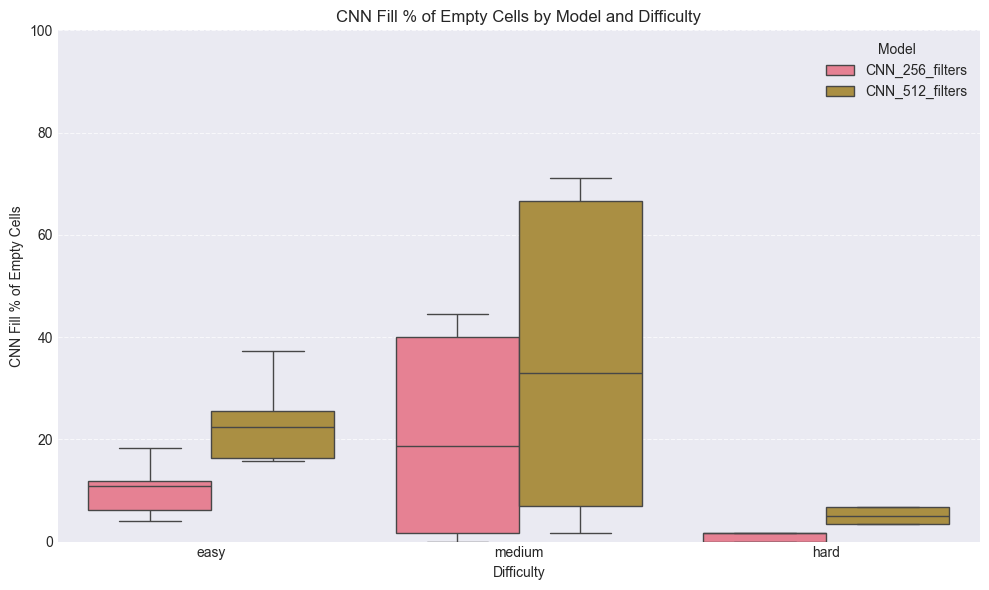

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load benchmark results
file_path = "hybrid_benchmark_results.csv"  # adjust if path differs
df = pd.read_csv(file_path)

# Compute CNN fill percentage
df['cnn_fill_percent'] = (df['cnn_cells_filled'] / df['total_empty_cells']) * 100

# Plot: CNN fill % by model and difficulty
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="difficulty", y="cnn_fill_percent", hue="model")

plt.title("CNN Fill % of Empty Cells by Model and Difficulty")
plt.ylabel("CNN Fill % of Empty Cells")
plt.xlabel("Difficulty")
plt.ylim(0, 100)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
